#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

Data preparation

In [1]:
import os
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

#Set the location of your data directory
data_dir = '/Users/zholler/Documents/Private/da_data_repo/'

In [3]:
# location folders
data_in = os.path.join(data_dir, 'bisnode-firms/clean/')
data_out = os.path.join(data_dir, 'bisnode-firms/')
output = os.path.join(data_out, 'output')
func = os.path.join(base_dir, 'da_case_studies/ch00-tech-prep/')
sys.path.append(func)

In [4]:
# Import the prewritten helper functions
from py_helper_functions import *

# Import data

In [6]:
csv_path = os.path.join(data_in,'cs_bisnode_panel.csv')
data = pd.read_csv(csv_path)

In [7]:
# drop variables with many NAs
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'])
data = data.query('year !=2016')


# Label engineering


In [8]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = data.set_index(['year','comp_id']).unstack(fill_value ='toReplace').stack().reset_index()
data = data.replace('toReplace',np.nan) #only way I could define it as NaN

In [9]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data['status_alive'] = (data['sales'] > 0 & (False == data['sales'].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
#Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data['default'] = ((data['status_alive'] == 1) & (data.groupby('comp_id')['status_alive'].shift(-2) == 0)).astype(int)

In [10]:
data = data.query('year <= 2013')

In [11]:
data['default'].describe()

count    417708.000000
mean          0.087276
std           0.282240
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [12]:
data['sales'].describe()

count    2.151190e+05
mean     4.860478e+05
std      3.885493e+06
min     -1.472559e+07
25%      5.344444e+03
50%      3.055555e+04
75%      1.083537e+05
max      1.110294e+08
Name: sales, dtype: float64

In [13]:
data['sales']=np.where(data['sales'] < 0, 1, data['sales'])#has to be outside of assin()
data = data.assign(
    ln_sales = np.where(data['sales'] > 0 , np.log(data['sales']), (np.where(data['sales'].isna(),np.nan,0))), #NaN remain NaN
    sales_mil=data['sales']/1000000,
    sales_mil_log = np.where(data['sales'] > 0, np.log(data['sales']/1000000), (np.where(data['sales'].isna(),np.nan,0)))
  )

/Users/zholler/.local/share/virtualenvs/da_case_studies-TSbAoTA8/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
/Users/zholler/.local/share/virtualenvs/da_case_studies-TSbAoTA8/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log


In [14]:
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)

In [15]:
# replace w 0 for new firms + add dummy to capture it
data['age']=np.where(data['year']-data['founded_year'] < 0, 0, data['year']-data['founded_year'])
data['new']=np.where(((data['age']<=1)|(data['balsheet_notfullyear']==1)),1,(np.where(data['age'].isna(),np.nan,0))) 
data['d1_sales_mil_log']=np.where(data['new']==1 , 0, np.where(data['new'].isna(),np.nan,data['d1_sales_mil_log']))
data['new']=np.where(data['d1_sales_mil_log'].isna(),1,data['new'] )
data['d1_sales_mil_log']=np.where(data['d1_sales_mil_log'].isna(),0,data['d1_sales_mil_log'])

# Sample design

In [16]:
# look at cross section
data=data.query('year==2012 & status_alive == 1')
# look at firms below 10m euro revenues and above 1000 euros
data=data.query('sales_mil<=10 & sales_mil>=0.001')

In [17]:
data['default'].describe()

count    21723.000000
mean         0.205681
std          0.404207
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [18]:
data.to_csv(data_out+'work5.csv',index=False)

# Feature engineering

In [5]:
current_csv_path = os.path.join(data_out, 'work5.csv')
data = pd.read_csv(current_csv_path)

In [6]:
# change some industry category codes
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

In [7]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0       50
26.0     1080
27.0      660
28.0     1954
29.0      287
30.0      168
32.0      148
33.0     1944
40.0      208
55.0     2266
56.0    12711
60.0      242
99.0        5
Name: comp_id, dtype: int64

In [8]:
# Firm characteristics
data['age2'] = data['age']**2
data['foreign_management'] = np.where(data['foreign'] >= 0.5, 1, np.where(data['foreign'].isna(), np.nan, 0))
data['gender_m'] = data['gender'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

In [9]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where(((data['intang_assets'] < 0) | (data['curr_assets'] < 0) | (data['fixed_assets'] < 0)), 1, 0)
data['flag_asset_problem'] = np.where(((data['intang_assets'].isna()) | (data['curr_assets'].isna()) | (data['fixed_assets'].isna())), np.nan, data['flag_asset_problem'])
data.groupby('flag_asset_problem').count()['comp_id']

flag_asset_problem
0.0    21700
1.0       13
Name: comp_id, dtype: int64

In [10]:
data['intang_assets'] = np.where(data['intang_assets'] < 0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets'] < 0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets'] < 0, 0, data['fixed_assets'])

In [11]:
# generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

count    2.171300e+04
mean     2.525889e+05
std      1.383198e+06
min      0.000000e+00
25%      6.466667e+03
50%      2.382963e+04
75%      9.346296e+04
max      1.046833e+08
Name: total_assets_bs, dtype: float64

In [12]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [13]:
# divide all pl_names elements by sales and create new column for it
data[[col +'_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

In [14]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col +'_bs' for col in bs_names]] =  data[bs_names].div(data['total_assets_bs'], axis='index').replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[[col +'_bs']] = np.where(data['total_assets_bs'].isna(), np.nan, data[col +'_bs'])

In [15]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

In [16]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

In [17]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)

In [18]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data = data.assign(
    flag_low_ceo_age = (data['ceo_age'] < 25).astype(int),
    flag_high_ceo_age = (data['ceo_age'] > 75).astype(int),
    flag_miss_ceo_age = (data['ceo_age'].isna()).astype(int))


data['ceo_age'] = np.where(data['ceo_age'] < 25, 25, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'] > 75, 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), data['ceo_age'].mean(), data['ceo_age'])
data['ceo_young'] = (data['ceo_age'] < 40).astype(int)

In [19]:
# number emp, very noisy measure
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), data['labor_avg'].mean(), data['labor_avg'])
data['flag_miss_labor_avg'] = (data['labor_avg'].isna()).astype(int)

In [20]:
data['labor_avg'].describe()

count    18569.000000
mean         0.621691
std          1.586800
min          0.083333
25%          0.097222
50%          0.229167
75%          0.513889
max         42.118057
Name: labor_avg, dtype: float64

In [21]:
data['labor_avg_mod'].describe()

count    21723.000000
mean         0.621691
std          1.467084
min          0.083333
25%          0.125000
50%          0.284722
75%          0.621691
max         42.118057
Name: labor_avg_mod, dtype: float64

In [22]:
data = data.drop(['labor_avg'], axis=1)

In [23]:
# create category type variables
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['default_f'] = data['default'].astype("category")
data['default_f'] = data['default_f'].cat.rename_categories(['no_default', 'default'])

In [24]:
########################################################################
 # sales 
########################################################################
data['sales_mil_log_sq'] = data['sales_mil_log']**2

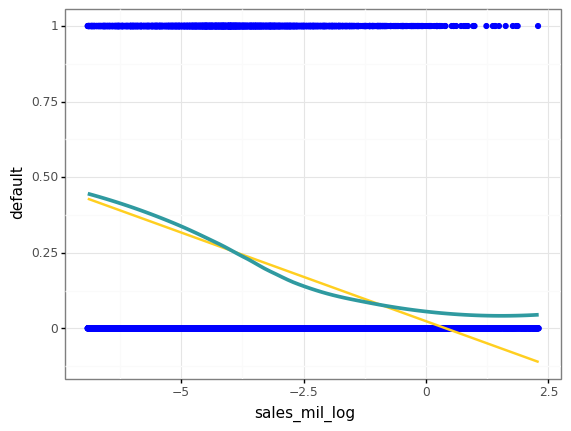

<ggplot: (325139056)>

In [30]:
ggplot(data, aes(x = "sales_mil_log", y = "default")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + x**2',  color=color[3], se = False) + geom_smooth(
    method = "loess", color=color[4], se = False, size=1.5, span=0.9) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()

In [31]:
# Linear regressions
ols_s = smf.ols('default ~ sales_mil_log + sales_mil_log_sq', data = data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     752.7
Date:                Sun, 06 Jun 2021   Prob (F-statistic):          8.90e-317
Time:                        00:16:44   Log-Likelihood:                -10418.
No. Observations:               21723   AIC:                         2.084e+04
Df Residuals:                   21720   BIC:                         2.087e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0519      0.006  

In [32]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data['d1_sales_mil_log'].describe()

count    21723.000000
mean        -0.077675
std          0.842694
min         -6.889406
25%         -0.158513
50%          0.000000
75%          0.103433
max          7.880300
Name: d1_sales_mil_log, dtype: float64

/Users/zholler/.local/share/virtualenvs/da_case_studies-TSbAoTA8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 56 rows containing missing values.


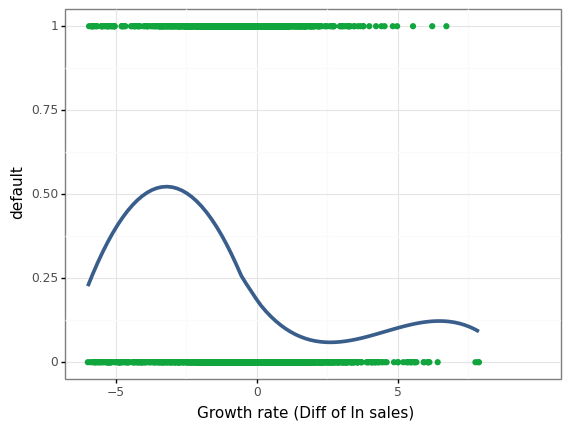

<ggplot: (325167535)>

In [33]:
ggplot(data, aes(x = 'd1_sales_mil_log', y = 'default')) + geom_point(
    color=color[1]) + geom_smooth(
    method = 'loess', color=color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln sales)', y='default') + scale_x_continuous(
    limits=(-6, 10), breaks = seq(-5, 10, by = 5)
) + theme_bw() 

In [34]:
# generate variables ---------------------------------------------------

data['flag_low_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] < -1.5, 1, 0)
data['flag_high_d1_sales_mil_log'] = np.where(data['d1_sales_mil_log'] > 1.5, 1, 0)
data['d1_sales_mil_log_mod'] = np.where(data['d1_sales_mil_log'] < -1.5, -1.5, 
                                        np.where(data['d1_sales_mil_log'] > 1.5, 1.5, data['d1_sales_mil_log']))
data['d1_sales_mil_log_mod_sq'] = data['d1_sales_mil_log_mod']**2

In [35]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind'])

In [36]:
# drop missing
data = data.dropna(subset = ['age', 'foreign', 'material_exp_pl', 'm_region_loc'])
data['age'].describe()

count    19036.000000
mean         8.701828
std          6.924531
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         34.000000
Name: age, dtype: float64

In [37]:
# drop unused factor levels
for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.remove_unused_categories()

/Users/zholler/.local/share/virtualenvs/da_case_studies-TSbAoTA8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 1151 rows containing missing values.


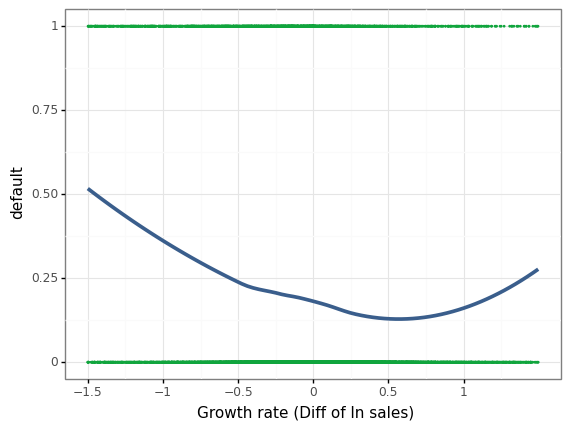

<ggplot: (325638479)>

In [38]:
ggplot(data, aes(x = 'd1_sales_mil_log', y = 'default')) + geom_point(
    size = 0.1, color = color[1]) + geom_smooth(
    method = 'loess', color = color[0], se = False, size=1.5, span=0.9) + labs(
    x='Growth rate (Diff of ln sales)', y='default') + scale_x_continuous(
    limits=(-1.5, 1.5), breaks = seq(-1.5, 1.5, by = 0.5)
) + theme_bw() 

/Users/zholler/.local/share/virtualenvs/da_case_studies-TSbAoTA8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 142 rows containing missing values.


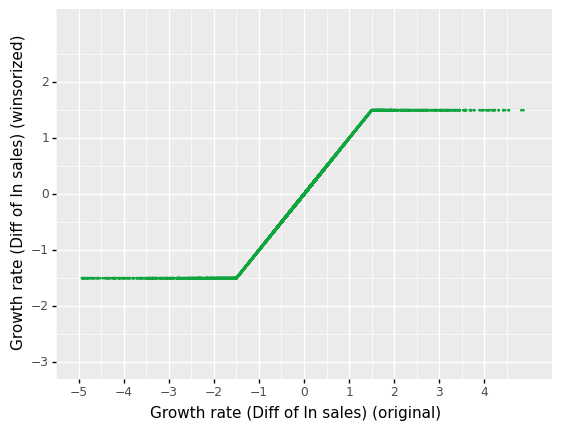

<ggplot: (325632907)>

In [39]:
ggplot(data, aes(x = 'd1_sales_mil_log', y = 'd1_sales_mil_log_mod')) + geom_point(
    size = 0.1, color = color[1]) + labs(
    x='Growth rate (Diff of ln sales) (original)', y='Growth rate (Diff of ln sales) (winsorized)'
) + scale_x_continuous(limits=(-5, 5), breaks = seq(-5, 5, by = 1)
) + scale_y_continuous(limits=(-3, 3), breaks = seq(-3, 3, by = 1))

In [52]:
data.to_csv(data_out+'bisnode_firms_clean.csv',index=False)